In [85]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

In [86]:
def drawgr(D, color, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(D, node_color=color, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(D, "weight")
    nx.draw_networkx_edge_labels(D, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


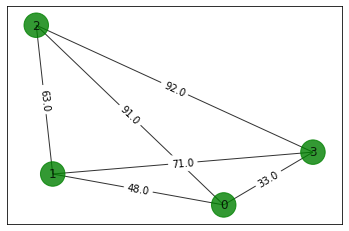

In [87]:
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

color = ["g" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
drawgr(tsp.graph, color, pos)

In [88]:
from itertools import permutations
import time
def classical_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_dist = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_dist:
            best_order = order
            last_best_dist = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_dist, best_order

In [89]:
t1 = time.time()
best_dist, best_order = classical_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_dist)
)
t2 = time.time()
print("Es dauert die Optimale Lösung zu finden: {:.6f}s".format(t2 - t1))

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0
Es dauert die Optimale Lösung zu finden: 0.001033s


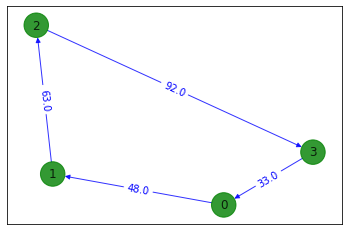

In [90]:
def draw_tsp_solution(D, order, color, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(D)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=D[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=color, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

draw_tsp_solution(tsp.graph, best_order, color, pos)

In [91]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [92]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [93]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2 = QuadraticProgramToQubo()
qubo = qp2.convert(qp)
qubitO, offset = qubo.to_ising()

spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitO.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitO)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, color, pos)

Note: Using a statevector_simulator with 16 qubits can be very expensive. Consider using the Aer qasm_simulator instead to take advantage of Aer's built-in fast Pauli Expectation


MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [3]:
from qiskit_optimization.applications.vertex_cover import VertexCover
import networkx as nx

seed = 42
algorithm_globals.random_seed = seed
qins = QuantumInstance(
    backend=Aer.get_backend("qasm_simulator"), shots=1000, seed_simulator=seed, seed_transpiler=seed
)

In [16]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
import time

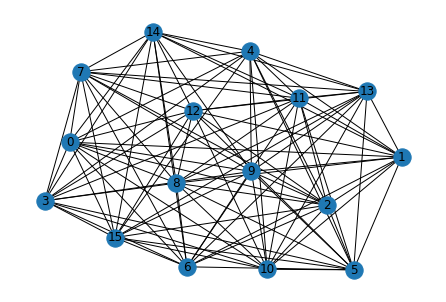

In [81]:
graph = nx.random_regular_graph(d=12, n=16, seed=seed)
pos = nx.spring_layout(graph, seed=seed)
prob = VertexCover(graph)
prob.draw(pos=pos)

In [82]:
qp = prob.to_quadratic_program()
print(qp.prettyprint())

Problem name: Vertex cover

Minimize
  x_0 + x_1 + x_10 + x_11 + x_12 + x_13 + x_14 + x_15 + x_2 + x_3 + x_4 + x_5
  + x_6 + x_7 + x_8 + x_9

Subject to
  Linear constraints (96)
    x_4 + x_9 >= 1  'c0'
    x_2 + x_4 >= 1  'c1'
    x_11 + x_4 >= 1  'c2'
    x_13 + x_4 >= 1  'c3'
    x_15 + x_4 >= 1  'c4'
    x_0 + x_4 >= 1  'c5'
    x_10 + x_4 >= 1  'c6'
    x_1 + x_4 >= 1  'c7'
    x_3 + x_4 >= 1  'c8'
    x_4 + x_5 >= 1  'c9'
    x_14 + x_4 >= 1  'c10'
    x_4 + x_7 >= 1  'c11'
    x_10 + x_9 >= 1  'c12'
    x_0 + x_9 >= 1  'c13'
    x_14 + x_9 >= 1  'c14'
    x_5 + x_9 >= 1  'c15'
    x_7 + x_9 >= 1  'c16'
    x_1 + x_9 >= 1  'c17'
    x_3 + x_9 >= 1  'c18'
    x_13 + x_9 >= 1  'c19'
    x_15 + x_9 >= 1  'c20'
    x_2 + x_9 >= 1  'c21'
    x_6 + x_9 >= 1  'c22'
    x_10 + x_5 >= 1  'c23'
    x_12 + x_5 >= 1  'c24'
    x_1 + x_5 >= 1  'c25'
    x_3 + x_5 >= 1  'c26'
    x_11 + x_5 >= 1  'c27'
    x_13 + x_5 >= 1  'c28'
    x_5 + x_6 >= 1  'c29'
    x_2 + x_5 >= 1  'c30'
    x_15 + x

objective function value: 13.0
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=1.0, x_7=1.0, x_8=1.0, x_9=1.0, x_10=1.0, x_11=1.0, x_12=1.0, x_13=0.0, x_14=1.0, x_15=1.0
status: SUCCESS

solution: [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
3.7699222564697266


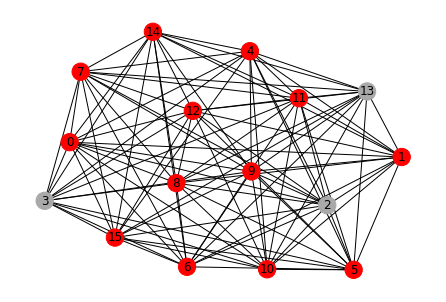

In [83]:
# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
t1=time.time()
result = meo.solve(qp)
t2=time.time()
print(result.prettyprint())
print("\nsolution:", prob.interpret(result))
print(t2-t1)
prob.draw(result, pos=pos)

objective function value: 0.0
variable values: x_0=0.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=0.0, x_10=0.0, x_11=0.0, x_12=0.0, x_13=0.0, x_14=0.0, x_15=0.0
status: INFEASIBLE

solution: []

time: 5.118313312530518


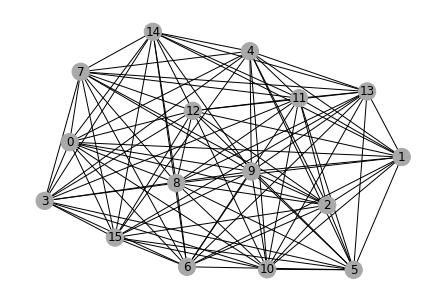

In [84]:
# QAOA
meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(qp)
print(result.prettyprint())
print("\nsolution:", prob.interpret(result))
print("\ntime:", result.min_eigen_solver_result.optimizer_time)
prob.draw(result, pos=pos)

In [23]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

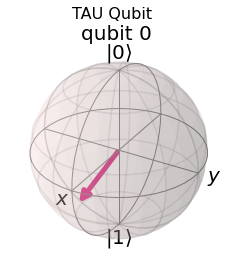

In [41]:
from qiskit.visualization import plot_bloch_multivector
import numpy as np
a=1+1j
b=4-3j
norm=np.sqrt(abs(a**2)+abs(b**2))
some_state=[a/norm,b/norm]
plot_bloch_multivector(state=some_state,title="TAU Qubit")
